In [1]:
import pandas as pd

In [2]:
!ls data

headlines.txt


- Read Data

In [7]:
def read_data(filename):
    with open(filename) as f:
        return pd.DataFrame([line.strip() for line in f], columns=['headline'])

In [8]:
df = read_data('data/headlines.txt')

In [13]:
import geonamescache

In [152]:
gc = geonamescache.GeonamesCache()
countries, cities = gc.get_countries(), gc.get_cities()

In [156]:
gc.get_cities_by_name('Miami Beach')

[{'4164143': {'geonameid': 4164143,
   'name': 'Miami Beach',
   'latitude': 25.79065,
   'longitude': -80.13005,
   'countrycode': 'US',
   'population': 92312,
   'timezone': 'America/New_York',
   'admin1code': 'FL'}}]

In [178]:
import unidecode
country_names = [unidecode.unidecode(country_dict['name']) for country_dict in countries.values()]
city_names = [unidecode.unidecode(city_dict['name']) for city_dict in cities.values()]
city_names = sorted(city_names, key=lambda x: len(x), reverse=True)
country_names  = sorted(country_names, key=lambda x: len(x), reverse=True)

In [38]:
import re

In [179]:
cities_regex = '|'.join(city_names)

In [180]:
countries_regex = '|'.join(country_names)

In [181]:
full_cities_regex    = '\\b(' + cities_regex + ')\\b'
# print(full_cities_regex[-1])
full_countries_regex = '\\b(' + countries_regex + ')\\b'
full_cities_regex = re.compile(full_cities_regex)
full_countries_regex = re.compile(full_countries_regex)

In [173]:
text = 'Miami Beach'
def city_matcher(text, full_cities_regex):
    match = full_cities_regex.search(text)
    return text[match.start():match.end()] if match is not None else None
city_matcher(text,full_cities_regex)

'Miami Beach'

In [153]:
# text = 'Zika Concerns are Spreading in Houston and Brazil'
# def cities_matcher(text, full_cities_regex):
#     matches = full_cities_regex.findall(text)
#     #print(matches[1][0])
#     lst_matches = [match[0] for match in matches] if len(matches)>0 else None
#     return ', '.join(lst_matches) if lst_matches is not None else None
# cities_matcher(text,full_cities_regex)

In [182]:
df['cities']    = [city_matcher(unidecode.unidecode(headline),full_cities_regex) for headline in df['headline']]
df['countries'] = [city_matcher(unidecode.unidecode(headline),full_countries_regex) for headline in df['headline']]

In [177]:
df.fillna(value=pd.np.nan, inplace=True)
df

,headline,cities,countries
0,Zika Outbreak Hits Miami,Miami,NaN
1,Could Zika Reach New York City?,New York City,NaN
2,First Case of Zika in Miami Beach,Miami Beach,NaN
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil
4,Dallas man comes down with case of Zika,Dallas,NaN
5,Trinidad confirms first Zika case,Trinidad,NaN
6,Zika Concerns are Spreading in Houston,Houston,NaN
7,Geneve Scientists Battle to Find Cure,Geneve,NaN
8,The CDC in Atlanta is Growing Worried,Atlanta,NaN
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,NaN


- let's save progress

In [184]:
df.to_json('result_json.json',orient='records')

In [185]:
ls

1. Extracting City and Country Information from News Headlines.ipynb
README.md
data/
environment.yml
result_json.json
step1_extraction.ipynb


In [189]:
import json
with open('result_json.json', "r") as fin:
    check_data = json.loads(fin.read())

In [190]:
check_data

[{'headline': 'Zika Outbreak Hits Miami',
  'cities': 'Miami',
  'countries': None},
 {'headline': 'Could Zika Reach New York City?',
  'cities': 'New York City',
  'countries': None},
 {'headline': 'First Case of Zika in Miami Beach',
  'cities': 'Miami Beach',
  'countries': None},
 {'headline': 'Mystery Virus Spreads in Recife, Brazil',
  'cities': 'Recife',
  'countries': 'Brazil'},
 {'headline': 'Dallas man comes down with case of Zika',
  'cities': 'Dallas',
  'countries': None},
 {'headline': 'Trinidad confirms first Zika case',
  'cities': 'Trinidad',
  'countries': None},
 {'headline': 'Zika Concerns are Spreading in Houston',
  'cities': 'Houston',
  'countries': None},
 {'headline': 'Geneve Scientists Battle to Find Cure',
  'cities': 'Geneve',
  'countries': None},
 {'headline': 'The CDC in Atlanta is Growing Worried',
  'cities': 'Atlanta',
  'countries': None},
 {'headline': 'Zika Infested Monkeys in Sao Paulo',
  'cities': 'Sao Paulo',
  'countries': None},
 {'headline':

# Step 2: Geolocation

In [191]:
df_new = pd.read_json('result_json.json')

In [192]:
df_new

,headline,cities,countries
0,Zika Outbreak Hits Miami,Miami,None
1,Could Zika Reach New York City?,New York City,None
2,First Case of Zika in Miami Beach,Miami Beach,None
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil
4,Dallas man comes down with case of Zika,Dallas,None
5,Trinidad confirms first Zika case,Trinidad,None
6,Zika Concerns are Spreading in Houston,Houston,None
7,Geneve Scientists Battle to Find Cure,Geneve,None
8,The CDC in Atlanta is Growing Worried,Atlanta,None
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,None


In [215]:
alternative_names = {unidecode.unidecode(city_dict['name']):city_dict['name'] for city_dict in cities.values()}

In [255]:
def extract_code_lat_long(city_name):
    #print(gc.get_cities_by_name(city_name))
    lst = gc.get_cities_by_name(city_name)
    if not lst and city_name in alternative_names:
        lst = gc.get_cities_by_name(alternative_names[city_name])
    best_cities =  sorted(lst, key=lambda x: list(x.values())[0]['population'],reverse=True)
    best_city= best_cities[0]
    #print(best_cities)
    code_lat_long = [(city['countrycode'],city['latitude'],city['longitude']) for city in best_city.values()]
    code, lat, long = code_lat_long[0]
    return code, lat, long
extract_code_lat_long('Milton')

('CA', 43.51681, -79.88294)

In [249]:
#del df['countries']
df.fillna(value=pd.np.nan, inplace=True)
df.dropna(subset = ["cities"], inplace=True);
df

,headline,cities
0,Zika Outbreak Hits Miami,Miami
1,Could Zika Reach New York City?,New York City
2,First Case of Zika in Miami Beach,Miami Beach
3,"Mystery Virus Spreads in Recife, Brazil",Recife
4,Dallas man comes down with case of Zika,Dallas
5,Trinidad confirms first Zika case,Trinidad
6,Zika Concerns are Spreading in Houston,Houston
7,Geneve Scientists Battle to Find Cure,Geneve
8,The CDC in Atlanta is Growing Worried,Atlanta
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo


In [250]:
all_info = [extract_code_lat_long(city) for city in df['cities']]

In [256]:
df['latitude'] = [info[1] for info in all_info]
df['longitude'] = [info[2] for info in all_info]
df['code'] = [info[0] for info in all_info]
df


,headline,cities,code,latitude,longitude
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667
5,Trinidad confirms first Zika case,Trinidad,BO,-14.83333,-64.90000
6,Zika Concerns are Spreading in Houston,Houston,US,29.76328,-95.36327
7,Geneve Scientists Battle to Find Cure,Geneve,CH,46.20222,6.14569
8,The CDC in Atlanta is Growing Worried,Atlanta,US,33.74900,-84.38798
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,BR,-23.54750,-46.63611


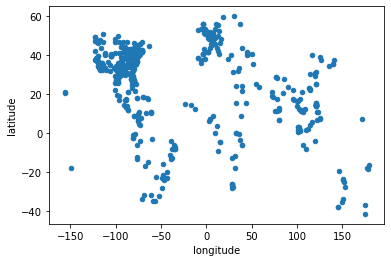

In [257]:
_ = df.plot.scatter(y='latitude', x='longitude')

In [261]:
df = df.rename(columns=dict(code="countrycode", cities="city"))

In [263]:
df.to_csv('data/processed_headlines_locations.csv')

# Let's cluster the data

In [273]:
import numpy as np
import matplotlib.pyplot as plt

In [282]:
data = [[long,lat] for long,lat in zip(df['longitude'],df['latitude'])]

In [299]:
from sklearn.cluster import KMeans, DBSCAN

cluster_model = KMeans(n_clusters=3)
assigned_bulls_eyes = cluster_model.fit_predict(data)



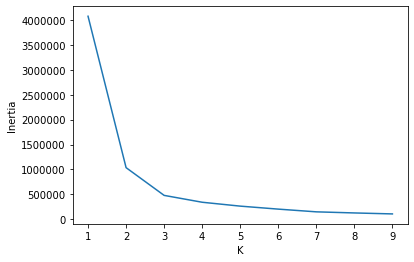

In [288]:
k_values = range(1, 10)
inertia_values = [KMeans(k).fit(data).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

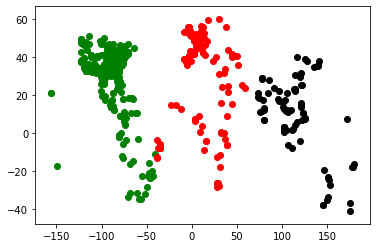

In [300]:
for bs_index in range(3):
    selected_darts = [data[i] for i in range(len(data))
                      if bs_index == assigned_bulls_eyes[i]]
    #print(np.array(selected_darts).T)
    #break
    x_coordinates, y_coordinates = np.array(selected_darts).T
    plt.scatter(x_coordinates, y_coordinates,
                color=['g', 'k','r'][bs_index])
plt.show()

- Let's try DBSCAN

In [315]:
import math

In [323]:
def gc_dist(point1,point2):
    def deg2rad(deg):
        return deg * (math.pi /180)
    R = 3958.8 #radius of earth in miles
    lat1 = point1[1]
    lat2 = point2[1]
    dLat= deg2rad(point2[1] - point1[1])
    dLon= deg2rad(point2[0] - point1[0])
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(deg2rad(lat1)) * math.cos(deg2rad(lat2)) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    return R * c


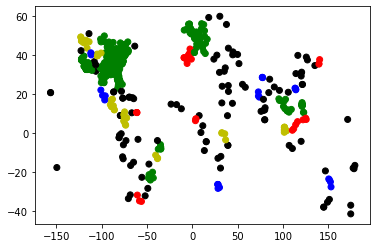

In [332]:
cluster_model = DBSCAN(eps=250,min_samples=3, metric= gc_dist)
rock_clusters = cluster_model.fit_predict(data)
len(set(rock_clusters))
colors = [['g', 'y', 'b','r','k'][cluster//7] for cluster in rock_clusters]
plt.scatter(df['longitude'], df['latitude'],
                color=colors)

In [357]:
df['cluster']= rock_clusters

In [358]:
df.head()

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,1
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0


In [360]:
gc_dist([25.77427,-80.19366][::-1], [40.71427,-74.00597][::-1])

1091.6602841495717

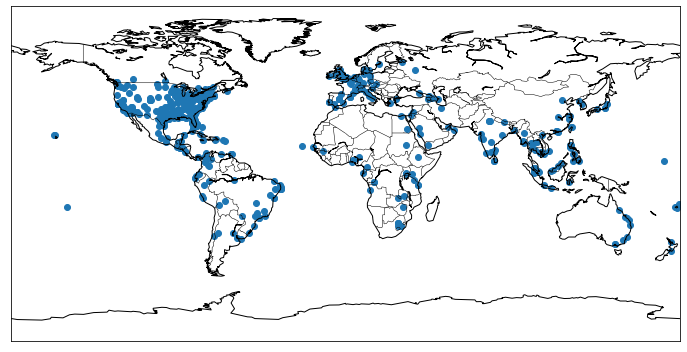

In [346]:
from mpl_toolkits.basemap import Basemap

map_ortho = Basemap()#projection='ortho', lat_0=40, lon_0=-95)
fig = plt.figure(figsize=(12, 8))
map_ortho.scatter(list(df['longitude']), list(df['latitude']), latlon=True)
map_ortho.drawcoastlines()
map_ortho.drawcountries()

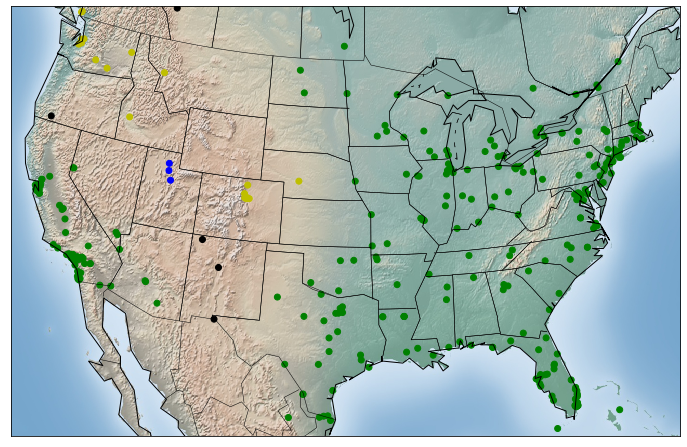

In [353]:
map_ortho = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119,
                  llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33,
                  lat_2=45)

fig = plt.figure(figsize=(12, 8))
map_ortho.shadedrelief()
map_ortho.scatter(list(df['longitude']), list(df['latitude']), latlon=True, color=colors)
map_ortho.drawcoastlines()
map_ortho.drawcountries()
map_ortho.drawstates()

In [ ]:
# function getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2) {
#   var R = 6371; // Radius of the earth in km
#   var dLat = deg2rad(lat2-lat1);  // deg2rad below
#   var dLon = deg2rad(lon2-lon1); 
#   var a = 
#     Math.sin(dLat/2) * Math.sin(dLat/2) +
#     Math.cos(deg2rad(lat1)) * Math.cos(deg2rad(lat2)) * 
#     Math.sin(dLon/2) * Math.sin(dLon/2)
#     ; 
#   var c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a)); 
#   var d = R * c; // Distance in km
#   return d;
# }

# function deg2rad(deg) {
#   return deg * (Math.PI/180)
# }